# Brain Segmentation

This tutorial will show how to use Fed-BioMed to perform image segmentation on 3D medical MRI images of brains, using the publicly available [IXI dataset](https://brain-development.org/ixi-dataset/). 
It uses a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) model for the segmentation, trained on data from 3 separate centers. 

Here we display a very complex case, using advanced Fed-BioMed functionalities such as:
- exploring the datasets in the federation
- loading a MedicalImageDataset
- monitoring training loss with Tensorboard

Parts of this tutorial are based on [TorchIO's tutorial](https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=OoHXr1a4_9Ll).

## Table of Contents

- [Task 1: Discovering datasets](#discover-datasets)
- [Task 2: MedicalFolderDataset class](#medicalfolderdataset)
- [Task 3: Federated feature analytics](#federated-feature-analytics)
- [Task 4: Train a UNet model](#training)
- [Task 5: Validation on a local holdout set](#validation)

In [1]:
%load_ext tensorboard

In [2]:
import os
import tabulate
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, SGD
from torch.utils.data import DataLoader
from monai.networks.nets import UNet
from monai.losses.dice import DiceLoss
from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)

from fedbiomed.common.training_plans import BaseTrainingPlan, TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager, MedicalFolderDataset
from fedbiomed.researcher.requests import Requests
from fedbiomed.researcher.aggregators import Aggregator, FedAverage
from fedbiomed.researcher.environ import environ
from fedbiomed.common.training_args import TrainingArgs
from fedbiomed.researcher.experiment import Experiment

2023-07-03 15:11:32,411 - Selected pickle protocol: '4'


In [3]:
%matplotlib inline

## Task 1: Discovering datasets <a name="discover-datasets"></a>

Let's discover which datasets are available for federated training in the network. 

##### Try it yourself!

Read the [documentation](https://fedbiomed.org/latest/developer/api/researcher/requests/) for the `Requests` class to figure out which function call can be used to list all the available datasets.

In [4]:
req = Requests()
datasets = req.list(verbose=False)

2023-07-03 15:11:35,240 fedbiomed INFO - Messaging researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7ffa9c238160>
2023-07-03 15:11:35,261 fedbiomed INFO - Listing available datasets in all nodes... 


In [5]:
pprint(datasets)

{'node_10797f2f-2524-4595-a1c6-f3c67e03add1': [{'data_type': 'medical-folder',
                                                'dataset_id': 'dataset_ae4dd6a8-1227-4379-8d3c-7a2caa0d9503',
                                                'dataset_parameters': {'index_col': 13},
                                                'description': '',
                                                'name': 'ixi site 2',
                                                'shape': {'T1': [83, 44, 55],
                                                          'T2': [83, 44, 55],
                                                          'demographics': [69,
                                                                           13],
                                                          'label': [83, 44, 55],
                                                          'num_modalities': 3},
                                                'tags': ['ixi-jupyter-sharkovsky']},
                        

### Filter results

There are a lot of datasets available! However, most of them are from nodes that are going to collaborate with other users, not you. To identify datasets that were intended for your use, you should look at the value of the `tags`.

##### Try it yourself!

Fill in the body of the for loop below such that the `datasets_for_me` variable follows these rules:

- it has the same structure as the `datasets` variable
- it has all and only the datasets whose tag contains your username

In [6]:
my_username = 'sharkovsky'
datasets_for_me = dict()
for node, _data in datasets.items():
    datasets_for_me[node] = list(filter( lambda dataset: any(my_username in x for x in dataset['tags']), _data))

In [7]:
pprint(datasets_for_me)

{'node_10797f2f-2524-4595-a1c6-f3c67e03add1': [{'data_type': 'medical-folder',
                                                'dataset_id': 'dataset_ae4dd6a8-1227-4379-8d3c-7a2caa0d9503',
                                                'dataset_parameters': {'index_col': 13},
                                                'description': '',
                                                'name': 'ixi site 2',
                                                'shape': {'T1': [83, 44, 55],
                                                          'T2': [83, 44, 55],
                                                          'demographics': [69,
                                                                           13],
                                                          'label': [83, 44, 55],
                                                          'num_modalities': 3},
                                                'tags': ['ixi-jupyter-sharkovsky']},
                        

### Tabulate results

##### Try it yourself!

Looking at the format of the `datasets_for_me` variable, produce a table with the following format using the [`tabulate`](https://github.com/astanin/python-tabulate#library-usage) package:

| site                                     |   dataset name   |  sample size   | 
| ---------------------------------------  |  ------  |  --- | 
| node_3d7f08fa-ee13-4033-8a01-93b448b6c8be | ixi  |   177 |



In [8]:
tabulate_sample_sizes = list()
for node, _data in datasets_for_me.items():
    for d in _data:
        if d['data_type'] == 'medical-folder':
            tabulate_sample_sizes.append([node, d['name'], d['shape']['demographics'][0]])
        else:
            tabulate_sample_sizes.append([node, d['name'], d['shape'][0]])
print(tabulate.tabulate(tabulate_sample_sizes, headers=('site', 'dataset name', 'sample size')))

site                                       dataset name              sample size
-----------------------------------------  ----------------------  -------------
node_10797f2f-2524-4595-a1c6-f3c67e03add1  ixi site 2                         69
node_10797f2f-2524-4595-a1c6-f3c67e03add1  MedNIST client 2                18000
node_10797f2f-2524-4595-a1c6-f3c67e03add1  Heart disease client 2            349
node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1  ixi site 1                        305
node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1  MedNIST client 1                18000
node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1  Heart disease client 1            391


## Task 2: MedicalFolderDataset <a name="medicalfolderdataset"></a>

To help you get familiar with this loading medical imaging data in Fed-BioMed, we will practice on a smaller dataset that we assume is available to you locally as a researcher. This is often the case in FL settings where the reseaercher has a small holdout dataset for local validation. 

We will use Fed-BioMed's built-in class for image segmentation tasks: [`MedicalFolderDataset`](https://fedbiomed.org/latest/developer/api/common/data/#fedbiomed.common.data.MedicalFolderDataset). 
This class supports several medical imaging modalities (think all the different types of MRI, CT, PET, etc..). It is optimized for segmentation tasks but can be applied to other tasks (e.g. classification, regression, ...). 
This class supports loading a set of patient demographics data in csv format, in addition to the imaging data.

The inputs to the `__init__` function are:
- root: the filesystem path where the root of the dataset is located
- data_modalities: the names of the modalities of interest for the input data
- target_modalities: the names of the modalities of interest for the data to be predicted
- transform: optional transformations to be performed on the input images
- target_transform: optional transformations to be performed on the target data
- demographics_transform: optional transformations to be performed on the demographics (csv) data

Let's create the dataset:

In [9]:
dataset = MedicalFolderDataset(
    root='/datasets/ixi/holdout',  
    data_modalities=['T1', 'T2'],   
    target_modalities='label',      
    transform=None,       
    target_transform=None,  
    demographics_transform=None)  

##### Try it yourself!

You can find out the total number of images with the `len` function, and access images individually with the `[idx]` operator, where `idx` is an integer index.

Note: `dataset[0]` will return a tuple corresponding to index `0`. The tuple will be in the form `(inputs, targets)`. 

What is the format of `inputs` and `targets`? How do you access a single image? What data type is it, what is its format and shape? How do you access the corresponding binary mask?

In [10]:
(inputs, targets) = dataset[0]
image_modalities, demographics = inputs
img_t1 = image_modalities['T1']
img_t2 = image_modalities['T2']
segm_mask = targets['label']

##### Try it yourself!

Plot two images. On the left, the raw input image. On the right, again the raw input image as background but overlayed with the ground truth segmentation.
Take some time to familiriaze yourself with the approach for making the overlay plot, and all the plotting arguments that we use.

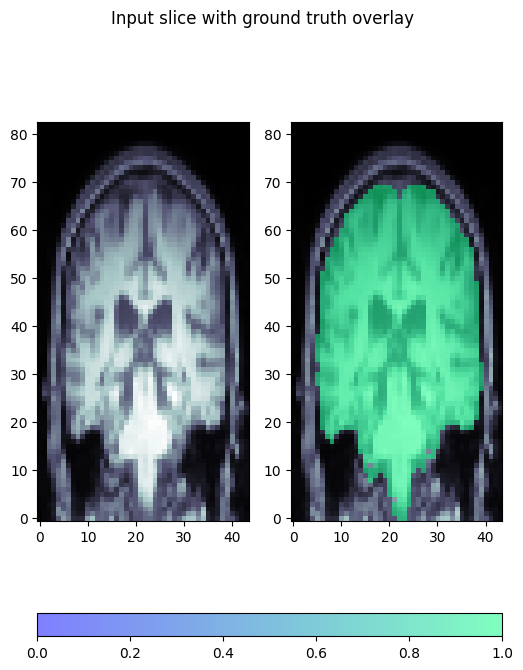

In [14]:
fig, ax = plt.subplots(1,2, figsize=(6,8))
slice_to_plot = 24

(image_modalities, demographics), target = dataset[42]
img = image_modalities['T1'][..., slice_to_plot]
ax[0].imshow(img, cmap='bone')
ax[0].invert_yaxis()

ax[1].imshow(img, cmap='bone')
label = target['label'][..., slice_to_plot]
plot = ax[1].imshow(np.ma.masked_where(
                        label < 0.5, 
                        label), cmap='winter', alpha=0.5, interpolation='none', vmin=0., vmax=1.)
ax[1].invert_yaxis()

fig.suptitle('Input slice with ground truth overlay')
fig.colorbar(plot, ax=ax, location='bottom')

## Task 3: Federated feature analytics <a name="federated-feature-analytics"></a>

We want to obtain some basic information about the distribution of values of our features (i.e. the pixels in the MRI images). Our ultimate goal is to obtain an histogram of the counts of pixel values, but this will require a few steps, showcasing how flexible and interactive Fed-BioMed can be.

<div class="alert alert-block alert-warning"><b>Hacking ahead!</b> <br> The following code will slightly bend the current intended usage of some Fed-BioMed classes. You will be working on the <em>alpha</em> version of a functionality which we are actively working on right now. </div>
    
### Federated Min and Max: TrainingPlan

We need to do some preliminary work in order to compute a federated histogram. One information that we need is the minimum and maximum pixel values over the whole federation, in order to compute a stable set of histogram bins across all the nodes in the federation. (Think about what would happen if we let each node compute their own histogram bins independently).

#### Implementation details

We are going to "hack" a `TorchTrainingPlan` in order to compute a minimum and a maximum instead of training a model. 

To understand what is going on exactly, you need the information below on some details about Fed-BioMed. If you are not interested, you can skip directly to the description of what you need to do to complete the code below.

The `TrainingPlan` should implement at least four important functions: 
- `init_model`: create the model (`nn.Module`) to be trained
- `init_optimizer`: create the optimizer
- `training_data`: to instantiate the dataset on the node (with customizations made by the researcher)
- `training_routine` or `training_step`: the actual training code. The latter is a simple shorthand if you only need to customize the training on a single batch, without worrying about managing the data loader, iterations, etc..

The diagram below simplifies the main steps that constitute a run of a federated experiment in Fed-BioMed:

![exp.run](http://www.plantuml.com/plantuml/svg/XPB1JiCm343l-Gf_mE03EA09ZTk6qCHzyXelZTGc8N6qmTTZiqNL6DKELHhx-JcAiooCcUiuc2Ihxtp2mB2bGfYxdlBhAL7s8qaG2z0f6OkCUom4csXfMBreF5FXGxrsl4bQSq7MgKYZAzbeHeE5s1WZNdXuRXfuWfg6Y1OsQnYr2np9kvuBD5AbWXKA5X0-ClgmfSygzOlppWVtFc1O06PNzVZ5DFjKRkCnpFHHOYAld8_onpjBIPfJw3oL-_Il_JuM4_lHVrCsbxkPe_cosIdtrzjbGYRGQrv7j69pETOqOv0K-q06O8WnmI5ATTV37hdh9GXdwxrp5AOaD0Lhz5Fstua6EjxSTgFrULs6saQQXgzfRWsO7PkH_8IXSvaSCjroIsaXR_u7)

#### Define data loading and transformations

In what follows, we provide a suggestion for defining the data loading. The `training_data` function will use [`MedicalFolderDataset`](https://fedbiomed.org/latest/developer/api/common/data/#fedbiomed.common.data.MedicalFolderDataset).

Additionally, we can define image transformations for the input images and the labels.

Finally, we define a transformation for the demographics data. Note that this is a required step to ensure that the demographics csv data is transformed into a torch Tensor usable by the training routine.

#### Our strategy: training_routine

We will implement a `training_routine` that does not really perform any training. Instead, it does one full pass over the whole dataset to find the maximum and the minimum.

#### Our strategy: the MinMaxTracker model

We will create a model that inherits from `nn.Module` but is not a neural network. Instead, it will simply contain a dictionary to store the minimum and maximum pixel values.

The `init_model` function of the `TrainingPlan` simply needs to return an instance of `MinMaxTracker`.

The `init_optimizer` function will return a dummy torch optimizer, since there is no actual optimization happening during our training.

The implementation details of how a model is handled can be a bit confusing at first. Here is a simplified diagram detailing the interactions between the main classes during a federated training round.

![diagram](http://www.plantuml.com/plantuml/svg/RLExZjim4Epv5OjKFk1E7s0amQL95o15oW32MbpJHFWWkAieby3_7egYRSc-nXwEPiZP4VNAWbb6xzGGVOg1Wi2FZ3ROOBux3F1F0TmUzJvgSfLSqsiM8CKiDi0701THzomer6ixo2vXHizxc1VFy3C0Iovm3uSO7No2h-YOdg1OaS6nVjYmv9BssCzu9OYZp8hLQK_myhaUrHoi7-K1FUc-vYAXp8l95eWISpE6r8mX2bMY3jp8Yi4oo8cWSSKxd224xblKewFd2syxwgekq9ZHbJ-POlvriy61GER-INUDfA3dS-lghExo6v9-8cjEmdVJcabjk-ERTFCYBdtpnh0jkszjhpleRoNqrmuGED5WSU47XymmPKp91ZCFNkdjy6exv5cjCqYxYtsEOw6evP6ixfCk6NRrjyTixgQp_j4HarXl_rBUNT5xpgWsbUDHYkuQRAdouRAX9BKgwo9F3eE2xISsn21boQ1WhgYiDHM00eQaidooAP46YLKGYg1JwzBKMIapmSSNODr0I8gdEPHZ3Nj0nx5-ZmnBOZZcw45PNpJj_HOP_Q5X5D9mY7A2mriz2p1eoCI4vLPJLarTV1KeoJFcQUsFmRqL_pMlCdEOMekoGIWVSI3uOamcWn9pxSmeLGJGTKLeO7z9EaJlns07d3V-RN7PjDsULmfwzEu_)

##### Try it yourself!

Fill in the code below in the `MinMaxTracker` and `training_routine`.


In [15]:
class FedMinMaxTrainingPlan(TorchTrainingPlan):    
    class MinMaxTracker(nn.Module):
        def __init__(self):
            super().__init__()
            self.min_max = {'min': torch.Tensor([np.infty]), 
                            'max': torch.Tensor([-np.infty])}
            
        def state_dict(self):
            return self.min_max
        
        def load_state_dict(self, params, strict=False):
            self.min_max = {'min': params['min'], 'max': params['max']}
            class MockMissingKeys:
                def __init__(self):
                    self.missing_keys = []
                    self.unexpected_keys = []
            return MockMissingKeys()
            
        def named_parameters(self):
            return self.min_max.items()

    def init_model(self, model_arguments):
        return FedMinMaxTrainingPlan.MinMaxTracker()
    
    def training_step(self, *args, **kwargs):
        pass
    
    def init_optimizer(self, optimizer_arguments):
        return SGD([torch.Tensor([0])], lr=0.)
        
    def init_dependencies(self):
        deps = [
            "from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)",
            "from fedbiomed.common.data import MedicalFolderDataset",
            'import numpy as np',
            'from torch.optim import SGD'
        ]
        
        return deps

    @staticmethod
    def demographics_transform(demographics: dict):
        return {}

    def training_data(self,  batch_size = 4):
    # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (44, 44, 56)
        training_transform = Compose([AddChannel(), Resize(common_shape)])
        target_transform = Compose([AddChannel(), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        dataset = MedicalFolderDataset(
            root=self.dataset_path,
            data_modalities='T1',
            target_modalities='label',
            transform=training_transform,
            target_transform=target_transform,
            demographics_transform=FedMinMaxTrainingPlan.demographics_transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': False}
        return DataManager(dataset, **train_kwargs)
    
    def training_routine(self,
                         history_monitor = None,
                         node_args = None):
        count = 0
        prev_min = self._model.get_weights()['min']
        prev_max = self._model.get_weights()['max']
        for data, target in self.training_data_loader:
            images, demographics = data
            image = images['T1']
            count += 1
            
            thismin = image.min()
            if thismin < prev_min:
                prev_min = thismin
            
            thismax = image.max()
            if thismax > prev_max:
                prev_max = thismax
                            
        self._model.set_weights({'min': prev_min, 
                                  'max': prev_max})  
                
        return count

### Federated Min and Max: Aggregator

The `Aggregator` must implement an `aggregate` function that returns a dictionary of model parameters.

##### Try it yourself!

Fill in the code for the `aggregate` function. 

The inputs are:
- `model_params`: a dictionary `{node_id: model_params_after_training}`, where `model_params_after_training` is the `state_dict` of the `MinMaxTracker` model after local training on the node.
- `weights`: a dictionary `{node_id: weight}` where the weight is a float between 0 and 1 computed as a proportion of the number of samples in the node to the total number of samples in the federation.

The output should be a dictionary with the same format as the `state_dict` of the `MinMaxTracker` model, i.e. it should be a dictionary:

```python
{
  'min': torch.Tensor([aggregated_minimum]),
  'max': torch.Tensor([aggregated_maximum])
}
```

In [16]:
class MinMaxAggregator(Aggregator):
    def __init__(self):
        super(MinMaxAggregator, self).__init__()
        self.aggregator_name = "MinMaxAggregator"
        
    def aggregate(self, model_params: dict, weights: dict, *args, **kwargs):
        all_minimums = all_maximums = list()
        for node_id, min_max in model_params.items():
            all_minimums.append(min_max['min'])
            all_maximums.append(min_max['max'])
        return {'min': min(all_minimums), 'max': max(all_maximums)}

### Define the experiment

<div class="alert alert-block alert-info"> <b>TAGS:</b> Replace %%%% in the tags with your username </div>

In [17]:
tags =  ['ixi-jupyter-sharkovsky']

exp = Experiment(tags=tags,
                 model_args={},
                 training_plan_class=FedMinMaxTrainingPlan,
                 training_args={},
                 round_limit=1,  # just a single round, with a pass over the whole dataset
                 aggregator=MinMaxAggregator(),
                 tensorboard=False,
                 save_breakpoints=False
                )

2023-07-03 15:24:37,093 fedbiomed INFO - Searching dataset with data tags: ['ixi-jupyter-sharkovsky'] for all nodes
2023-07-03 15:24:47,106 fedbiomed INFO - Node selected for training -> node_10797f2f-2524-4595-a1c6-f3c67e03add1
2023-07-03 15:24:47,107 fedbiomed INFO - Node selected for training -> node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1
2023-07-03 15:24:47,108 fedbiomed INFO - Checking data quality of federated datasets...
Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-07-03 15:24:47,109 fedbiomed DEBUG - using native torch optimizer
2023-07-03 15:24:47,110 fedbiomed DEBUG - Model file has been saved: /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0033/my_model_9fa23f7d-e9a4-4505-957b-5e27cac51a77.py
2023-07-03 15:24:47,122 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/f

In [18]:
exp.run_once()

2023-07-03 15:24:47,139 fedbiomed INFO - Sampled nodes in round 0 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:24:47,139 fedbiomed INFO - Sending request 
					 To: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '7de014e1-0fac-4346-81f6-b2901f7d71c8', 'training_args': {'optimizer_args': {}, 'batch_size': 1, 'epochs': None, 'num_updates': None, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'log_interval': 10, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {}, 'round': 0, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_clipping_range': None, 'command': 'train', 'training_

1

##### Try it yourself!

How can you access the minimum and maximum over the whole federation, after aggregation? 

Hint: the experiment holds a copy of the training plan, which contains the model.

In [19]:
fed_min = exp.training_plan().model().state_dict()['min']
fed_max = exp.training_plan().model().state_dict()['max']

### Federated Histogram: TrainingPlan

We want to compute the average histogram of pixel values, where the average is computed over the different images.

#### Our strategy: training_routine

We will implement a `training_routine` that does not really perform any training. Instead, it does one full pass over the whole dataset to compute the average histogram per image.

#### Our strategy: the FedHistogram model

We will create a model that inherits from `nn.Module` but is not a neural network. Instead, it will simply contain a dictionary to store the histogram, minimum and maximum pixel values (computed before) and the number of bins. Note that the real "parameter" of this model, i.e. the one that will be updated, is the histogram data. All the rest are static values that will not be updated nor aggregated. We will use `model_arguments` and `training_arguments` to pass these values.

The `init_model` function of the `TrainingPlan` simply needs to return an instance of `FedHistogram`.

The `init_optimizer` function will return a dummy torch optimizer, since there is no actual optimization happening during our training.

#### Our strategy: training_data

The `training_data` function will use [`MedicalFolderDataset`](https://fedbiomed.org/latest/developer/api/common/data/#fedbiomed.common.data.MedicalFolderDataset).


##### Try it yourself!

Fill in the code for `FedHistogram`, `init_model` and `training_routine`.

In [20]:
class FedHistogramTrainingPlan(TorchTrainingPlan):    
    class FedHistogram(nn.Module):
        def __init__(self, bin_min=0., bin_max=1e+5, nbins=10):
            super().__init__()
            self.hist_data = {'hist': torch.Tensor([np.nan]),
                              'bin_min': torch.Tensor([bin_min]),
                              'bin_max': torch.Tensor([bin_max]),
                              'nbins': torch.Tensor([nbins])}
            
        def state_dict(self):
            return self.hist_data
        
        def load_state_dict(self, params, strict=False):
            self.hist_data = params
            class MockMissingKeys:
                def __init__(self):
                    self.missing_keys = []
                    self.unexpected_keys = []
            return MockMissingKeys()
            
        def named_parameters(self):
            return self.hist_data.items()

    def init_model(self, model_args):
        return FedHistogramTrainingPlan.FedHistogram(
            bin_min = model_args['bin_min'],
            bin_max = model_args['bin_max'],
            nbins = model_args['nbins']
        )
    
    def training_step(self, *args, **kwargs):
        pass
    
    def init_optimizer(self, optimizer_arguments):
        return SGD([torch.Tensor([0])], lr=0.)
        
    def init_dependencies(self):
        deps = [
            "from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)",
            "from fedbiomed.common.data import MedicalFolderDataset",
            'import numpy as np',
            'from torch.optim import SGD'
        ]
        
        return deps

    @staticmethod
    def demographics_transform(demographics: dict):
        return {}

    def training_data(self,  batch_size = 4):
    # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (44, 44, 56)
        training_transform = Compose([AddChannel(), Resize(common_shape)])
        target_transform = Compose([AddChannel(), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        dataset = MedicalFolderDataset(
            root=self.dataset_path,
            data_modalities='T1',
            target_modalities='label',
            transform=training_transform,
            target_transform=target_transform,
            demographics_transform=FedHistogramTrainingPlan.demographics_transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': False}
        return DataManager(dataset, **train_kwargs)
    
    def training_routine(self,
                         history_monitor = None,
                         node_args = None):
        
        hist_metadata = self._model.get_weights()
        nbins = int(hist_metadata['nbins'].numpy().tolist()[0])
        bin_min = hist_metadata['bin_min'].numpy().tolist()[0]
        bin_max = hist_metadata['bin_max'].numpy().tolist()[0]
        
        count = 0
        hist = hist_metadata['hist']
        for data, target in self.training_data_loader:
            images, demographics = data
            image = images['T1']
            count += 1
            
            if count==1 :
                hist, _ = np.histogram(image.flatten().numpy(), 
                                       bins=nbins, 
                                       range=(bin_min, bin_max))
            else:
                tmp_hist_, _ = np.histogram(image.flatten().numpy(), 
                                       bins=nbins, 
                                       range=(bin_min, bin_max))
                hist += tmp_hist_
                                
        self._model.set_weights({'hist': hist / np.array([float(count)]), 
                                 'nbins': hist_metadata['nbins'],
                                 'bin_min': hist_metadata['bin_min'],
                                 'bin_max': hist_metadata['bin_max']}) 
                
        return count

### Federated Histogram: Aggregator

The `Aggregator` must implement an `aggregate` function that returns a dictionary of model parameters.
In this case it is important to compute a weighted average of the histograms returned from each node (think about why a non-weighted mean is biased). For this, you can use the `weights` argument of the `aggregate` function. 

##### Try it yourself!

Fill in the code for the `aggregate` function.

Reminder, the inputs to `aggregate` are:
- `model_params`: a dictionary `{node_id: model_params_after_training}`, where `model_params_after_training` is the `state_dict` of the `MinMaxTracker` model after local training on the node.
- `weights`: a dictionary `{node_id: weight}` where the weight is a float between 0 and 1 computed as a proportion of the number of samples in the node to the total number of samples in the federation.

In [21]:
class HistAggregator(Aggregator):
    def __init__(self):
        super(HistAggregator, self).__init__()
        self.aggregator_name = "HistAggregator"
        
    def aggregate(self, model_params: list, weights: list, *args, **kwargs):
        hist = None
        for node_id, hist_data in model_params.items():
            if hist is None:
                hist = hist_data['hist']*weights[node_id]
            else:
                hist += hist_data['hist']*weights[node_id]
        return {'hist': hist,
                'nbins': hist_data['nbins'],
                'bin_min': hist_data['bin_min'],
                'bin_max': hist_data['bin_max']}

### Define the experiment

This time we will use `model_args` to pass to the node the federated minimum and maximum (computed before) as well as the number of bins.

<div class="alert alert-block alert-warning"> <b>Seralization:</b> Arguments are sent over the network to the nodes: this requires that they can be serialized. </div>

Our computed values for the federated minimum and maximum are not serializable because they are `torch.Tensor`: you need to find a way to convert them to regular python `float`.

In [22]:
model_args = {
    'bin_min': fed_min.detach().numpy().tolist(),
    'bin_max': fed_max.detach().numpy().tolist(),
    'nbins': 100
}

<div class="alert alert-block alert-info"> <b>TAGS:</b> Replace %%%% in the tags with your username </div>

In [23]:
tags =  ['ixi-jupyter-sharkovsky']

exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=FedHistogramTrainingPlan,
                 training_args={},
                 round_limit=1,
                 aggregator=HistAggregator(),
                 tensorboard=False,
                 save_breakpoints=False
                )

2023-07-03 15:25:08,221 fedbiomed INFO - Searching dataset with data tags: ['ixi-jupyter-sharkovsky'] for all nodes
2023-07-03 15:25:18,234 fedbiomed INFO - Node selected for training -> node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1
2023-07-03 15:25:18,235 fedbiomed INFO - Node selected for training -> node_10797f2f-2524-4595-a1c6-f3c67e03add1
2023-07-03 15:25:18,238 fedbiomed INFO - Checking data quality of federated datasets...
Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-07-03 15:25:18,239 fedbiomed DEBUG - using native torch optimizer
2023-07-03 15:25:18,240 fedbiomed DEBUG - Model file has been saved: /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0034/my_model_70d7233b-531d-4d27-b244-706d6027db39.py
2023-07-03 15:25:18,250 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/f

In [24]:
exp.run_once()

2023-07-03 15:25:18,264 fedbiomed INFO - Sampled nodes in round 0 ['node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1', 'node_10797f2f-2524-4595-a1c6-f3c67e03add1']
2023-07-03 15:25:18,264 fedbiomed INFO - Sending request 
					 To: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': 'f055eee4-41aa-4562-aad1-44f0e78d0a7c', 'training_args': {'optimizer_args': {}, 'batch_size': 1, 'epochs': None, 'num_updates': None, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'log_interval': 10, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {'bin_min': -4.25, 'bin_max': 10791.6669921875, 'nbins': 100}, 'round': 0, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 's

1

#### Sanity check

It is always good to check the outputs of our calculations. 
What should the sum of all values in the aggregated histogram be equal to?

In [25]:
sum_of_pixel_counts = exp.training_plan().model().state_dict()['hist'].sum()
expected_value = 44*44*56
print(f"The sum of average pixel counts {sum_of_pixel_counts} "
      f"should be equal to the total image size {expected_value}")

The sum of average pixel counts 108415.99999999999 should be equal to the total image size 108416


### Plot the histograms

#### The aggregated histogram

##### Try it yourself
1. Using the values from `model_args`, obtain the size (the width) of each bin
2. Compute the array of bin edges
3. plot the histogram using the ax.bar function

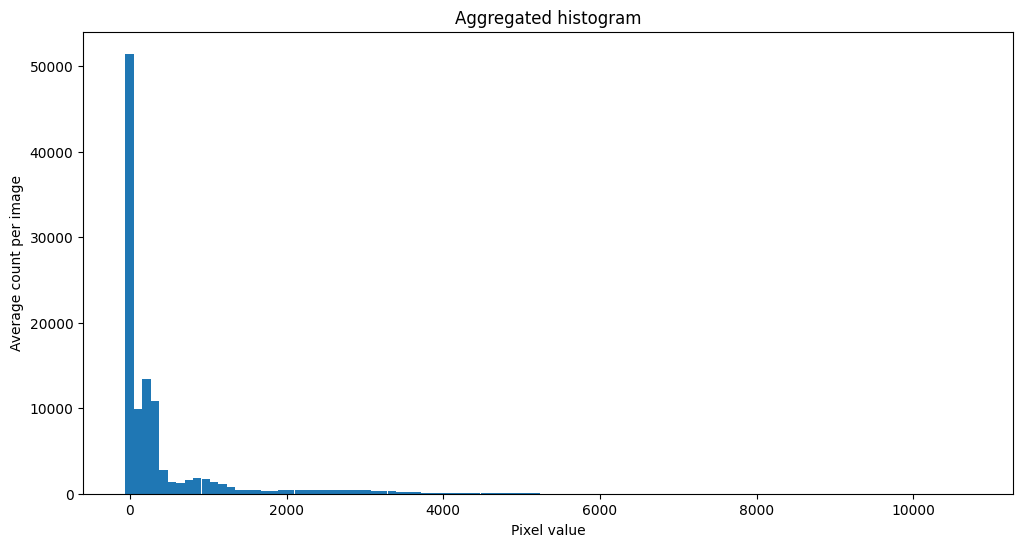

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
width_histogram_bin = (model_args['bin_max'] - model_args['bin_min'])/model_args['nbins']
bin_edges = np.arange(start=model_args['bin_min'],
                      stop=model_args['bin_max'],
                      step=width_histogram_bin)

ax.bar(bin_edges, 
       exp.training_plan().model().state_dict()['hist'], 
       width=0.99*width_histogram_bin)
_ = ax.set_ylabel('Average count per image')
_ = ax.set_xlabel('Pixel value')
_ = ax.set_title('Aggregated histogram')

#### The node-wise histograms

##### Try it yourself

You can access the models' state_dicts (after training) through the `exp.training_replies()` function. The output is a dictionary of the format `{round: node_replies}`, where `node_replies` is a list of replies. Each reply is a dictionary, where `node_id` and `params` are the most important keys for this task.

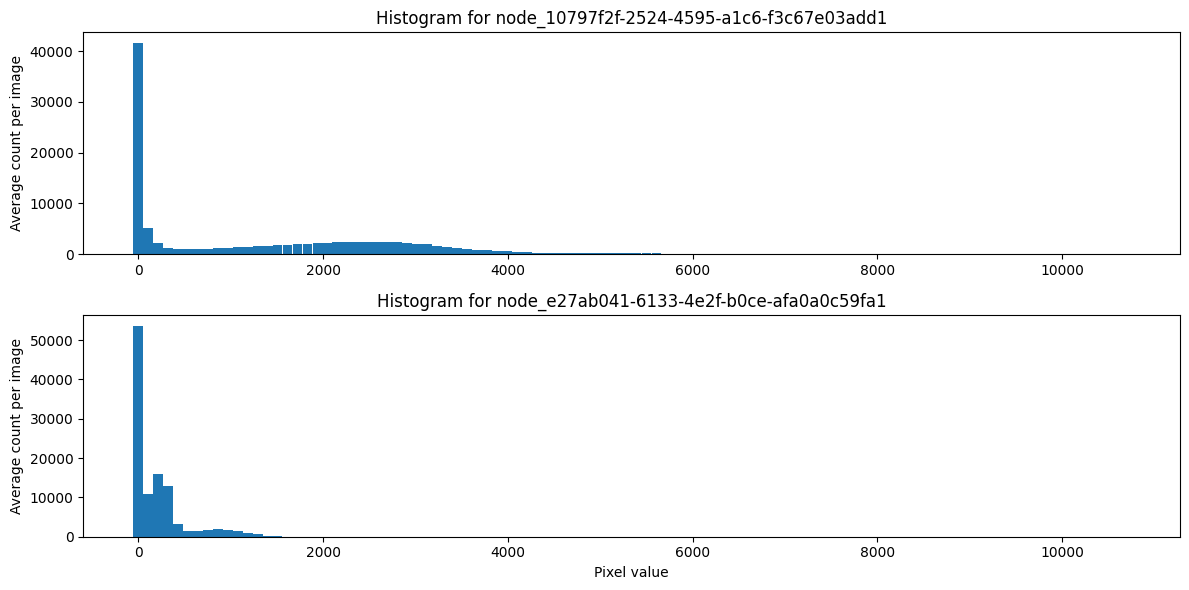

In [27]:
fig, ax = plt.subplots(2,1,figsize=(12,6))

width_histogram_bar = (model_args['bin_max'] - model_args['bin_min'])/model_args['nbins']
bin_edges = np.arange(start=model_args['bin_min'],
                     stop=model_args['bin_max'],
                     step=width_histogram_bar)

for i in range(2):
    hist_data = exp.training_replies()[0][i]['params']['hist']
    node_id = exp.training_replies()[0][i]['node_id']
    ax[i].bar(bin_edges, hist_data, width=0.99*width_histogram_bar)
    _ = ax[i].set_ylabel('Average count per image')
    _ = ax[i].set_title(f'Histogram for {node_id}')
_ = ax[1].set_xlabel('Pixel value')
fig.tight_layout()

##### Try it yourself!

What happens if we normalize the images while loading them? 
Add `NormalizeIntensity()` as an additional transform for the loaded images in the `TrainingPlan`, and check how the histogram changes shape.

## Task 4: Training a UNet model for the brain segmentation task <a name="training"></a>

## Create a Training Plan

We create a training plan that incorporates the UNet model. 

### Define the neural network model

We recommend using MONAI's [UNet](https://docs.monai.io/en/stable/networks.html#unet) implementation.

We define the model in the `__init__` and `forward` functions of the training plan. 

### Define the loss function
Loss function is computed based on the Dice Loss.

_Carole H Sudre, Wenqi Li, Tom Vercauteren, Sebastien Ourselin, and M Jorge Cardoso. Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations. In Deep learning in medical image analysis and multimodal learning for clinical decision support, pages 240–248. Springer, 2017._

### Define training step

Here we take as input one batch of (data, target), train the model and compute the loss function. 

Note that the `MedicalFolderDataset` class returns `data` as a tuple of `(images, demographics)`, where:
- `images` is a `dict` of `{modality: image`} (after image transformations)
- `demographics` is a `dict` of `{column_name: values}` where the column names are taken from the demographics csv file
while the `target` is a `dict` of `{modality: image`} (after target transformations). 

In our case, the modality used is `T1` for the input images, while the modality used for the target is `label`. We also ignore the values of the demographics data during training because the UNet model only takes images as input, but the code provided still shows the recommended way to handle such data. 


In [28]:
class UNetTrainingPlan(TorchTrainingPlan):
    
    def init_model(self, model_args):
        n_base_filters = model_args.get('base_filters',10)
        return UNet(
                spatial_dims = model_args.get('dimensions',3), 
                in_channels = model_args.get('in_channels',1), 
                out_channels = model_args.get('out_channels',2), 
                channels = (n_base_filters, 
                           2*n_base_filters,
                           4*n_base_filters), 
                strides = (2,2), 
                kernel_size=3, 
                up_kernel_size=3, 
                num_res_units=0, 
                act='PRELU', 
                norm='INSTANCE', 
                dropout=0.0, 
                bias=True, 
                adn_ordering='NDA'
            )
    
    def init_optimizer(self, optimizer_args):
        if optimizer_args.get('opt_name', 'not specified') == 'adamw':
            optimizer = AdamW(self.model().parameters(), lr=optimizer_args.get('lr', 0.001))
        else:
            optimizer = SGD(self.model().parameters(), lr=optimizer_args.get('lr', 0.001))
        return optimizer
    
    def init_dependencies(self):
        deps = [
            "from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)",
            "from monai.losses.dice import DiceLoss",
            "import torch.nn as nn",
            'import torch.nn.functional as F',
            "from fedbiomed.common.data import MedicalFolderDataset",
            'import numpy as np',
            'from torch.optim import AdamW, SGD',
            'from monai.networks.nets import UNet',
            'from fedbiomed.common.logger import logger']
        
        return deps
    
    @staticmethod
    def get_dice_loss(output, target, epsilon=1e-9):
        loss = DiceLoss(include_background=False, sigmoid=False)
        return loss(output, target)

    @staticmethod
    def demographics_transform(demographics: dict):
        return {}

    def training_data(self,  batch_size = 4):
    # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (44, 44, 56)
        training_transform = Compose([AddChannel(), Resize(common_shape), NormalizeIntensity(),])
        target_transform = Compose([AddChannel(), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        dataset = MedicalFolderDataset(
            root=self.dataset_path,
            data_modalities='T1',
            target_modalities='label',
            transform=training_transform,
            target_transform=target_transform,
            demographics_transform=UNetTrainingPlan.demographics_transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        return DataManager(dataset, **train_kwargs)
    
    
    def training_step(self, data, target):
        #this function must return the loss to backward it 
        img = data[0]['T1']
        demographics = data[1]
        logits = self.model().forward(img)
        output = F.softmax(logits, dim=1)
        loss = UNetTrainingPlan.get_dice_loss(output, target['label'])
        avg_loss = loss.mean()
        return avg_loss
    
    def testing_step(self, data, target):
        img = data[0]['T1']
        demographics = data[1]
        target = target['label']
        logits = self.model().forward(img)
        prediction = F.softmax(logits, dim=1)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        avg_loss = loss.mean()  # average per batch
        return avg_loss


## Define Parameters

Here you can define `model_args` and `training_args`, two dictionaries that contain parameters and hyperparameters for training and model definition. This provides a flexible way to explore the hyperparameter space without changing the `TrainingPlan`, which has potentially been fixed and validated by the clinical partners.


##### Try it yourself!

Change any of the parameters below to explore the space of hyperparameters. Please be mindful of the limited available resources when changing parameters that may require more computing power, such as `base_filters` and especially `batch_size`.

In [29]:
model_args = {
    'in_channels': 1,
    'out_channels': 2,
    'dimensions': 3,
    'base_filters': 10,
}

training_args = {
    'batch_size': 4,
    'num_updates': 8, 
    'dry_run': False,
    'log_interval': 2,
    'test_ratio' : 0.1,
    'test_on_global_updates': True,
    'test_on_local_updates': False,
    'optimizer_args': {
        'opt_name': 'adamw',
        'lr': 0.001
    }
}

num_rounds = 15

## Dry run your `TrainingPlan` locally

Since we have an holdout dataset available locally, we are going to test that the `TrainingPlan` is able to run locally, before we perform the federated training.

##### Try it yourself!

First, create a dataloader following these steps:
1. instantiate a `UNetTrainingPlan` object
2. call [`post_init`](https://fedbiomed.org/latest/developer/api/common/training_plans/#fedbiomed.common.training_plans._torchnn.TorchTrainingPlan.post_init) on the training plan. Note: you will need to instantiate a [`TrainingArgs`](https://fedbiomed.org/latest/developer/api/common/training_args/) object from the `training_args` dict
3. set the training plan's `dataset_path` to `/datasets/ixi/holdout`
4. Call the `training_data` function from the loaded experiment's training plan to obtain a [`TorchDataManager`](https://fedbiomed.org/latest/developer/api/common/data/#fedbiomed.common.data.TorchDataManager) 
5. Use the `_dataset` attribute of the data manager to instantiate a torch `DataLoader` (set a small batch size 

Then, perform one training iteration to check that it completes without errors:
1. create a for loop iterating on the dataloader
2. call the training plan's `training_step` method
3. `break` after the first iteration

In [30]:
dryrun_tp = UNetTrainingPlan()
dryrun_tp.post_init(model_args, TrainingArgs(training_args, only_required=False))
dryrun_tp.dataset_path = '/datasets/ixi/holdout'
dryrun_dataloader = DataLoader(dryrun_tp.training_data()._dataset, batch_size=2)
for (inputs, targets) in dryrun_dataloader:
    avg_loss = dryrun_tp.training_step(inputs, targets)
    break

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-07-03 15:25:34,004 fedbiomed DEBUG - using native torch optimizer
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


<div class="alert alert-block alert-info"> <b>TAGS:</b> Replace %%%% in the tags with your username </div>

In [31]:
tags =  ['ixi-jupyter-sharkovsky']

exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=UNetTrainingPlan,
                 training_args=training_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 tensorboard=True,
                 save_breakpoints=True
                )

2023-07-03 15:25:34,228 fedbiomed INFO - Searching dataset with data tags: ['ixi-jupyter-sharkovsky'] for all nodes
2023-07-03 15:25:44,242 fedbiomed INFO - Node selected for training -> node_10797f2f-2524-4595-a1c6-f3c67e03add1
2023-07-03 15:25:44,243 fedbiomed INFO - Node selected for training -> node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1
2023-07-03 15:25:44,245 fedbiomed INFO - Checking data quality of federated datasets...
2023-07-03 15:25:44,249 fedbiomed DEBUG - using native torch optimizer
2023-07-03 15:25:44,250 fedbiomed DEBUG - Model file has been saved: /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/my_model_fc0d2921-9797-4a5c-94fa-4beda077391d.py
2023-07-03 15:25:44,260 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/my_model_fc0d2921-9797-4a5c-94fa-4beda077391d.py successful, with status code 201
2023-07-03 15:25:44,272 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/fedb

#### Run tensorboard

Follow the [instructions](https://ai4health-2023.gitlabpages.inria.fr/ai4health-fedbiomed.gitlabpages.inria.fr/fedbiomed-tutorial/tensorboard-instructions.html) to obtain a port number, and run the commands below

In [32]:
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [33]:
tensorboard --logdir "$tensorboard_dir" --host 0.0.0.0 --port 6006

The tensorboard plots should look like this:
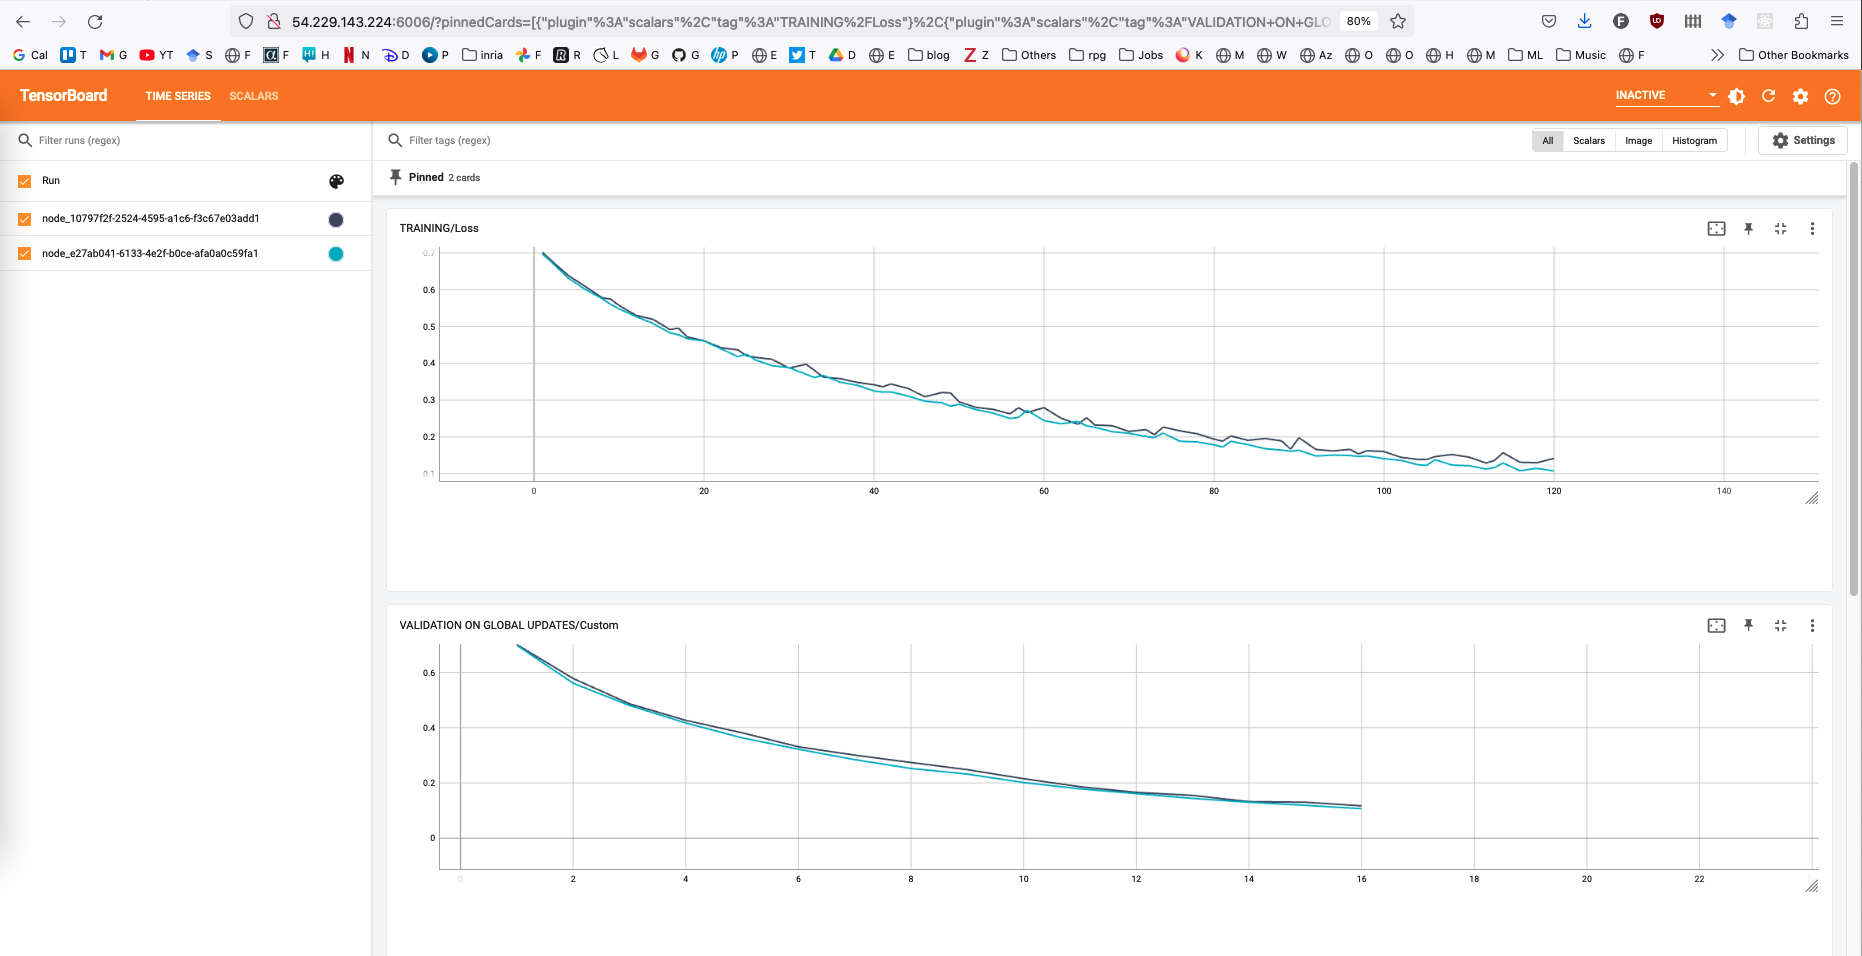

#### Run the experiment

In [34]:
print(f"Saving breakpoints to {exp.experimentation_folder()}")

Saving breakpoints to Experiment_0035


In [35]:
exp.run()

2023-07-03 15:25:45,809 fedbiomed INFO - Sampled nodes in round 0 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:25:45,809 fedbiomed INFO - Sending request 
					 To: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '68a226ac-6cdb-4a84-a21f-60303da18ecc', 'training_args': {'batch_size': 4, 'num_updates': 8, 'dry_run': False, 'log_interval': 2, 'test_ratio': 0.1, 'test_on_global_updates': True, 'test_on_local_updates': False, 'optimizer_args': {'opt_name': 'adamw', 'lr': 0.001}, 'epochs': None, 'batch_maxnum': None, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {'in_channels': 1, 'out_channels': 2, 'dimensions': 3, 'base_filters': 10}, 'round': 0, 'secagg_servkey_id': None, 'secagg_bipr

2023-07-03 15:25:55,857 fedbiomed DEBUG - researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87
2023-07-03 15:25:55,858 fedbiomed INFO - Sending request 
					 To: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '68a226ac-6cdb-4a84-a21f-60303da18ecc', 'training_args': {'batch_size': 4, 'num_updates': 8, 'dry_run': False, 'log_interval': 2, 'test_ratio': 0.1, 'test_on_global_updates': True, 'test_on_local_updates': False, 'optimizer_args': {'opt_name': 'adamw', 'lr': 0.001}, 'epochs': None, 'batch_maxnum': None, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {'in_channels': 1, 'out_channels': 2, 'dimensions': 3, 'base_filters': 10}, 'round': 1, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_clipping_range': None

2023-07-03 15:26:05,901 fedbiomed DEBUG - researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87
2023-07-03 15:26:06,085 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 3 | Iteration: 1/1 (100%) | Samples: 6/6
 					 Custom: 0.467660 
					 ---------
2023-07-03 15:26:06,225 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 3 | Iteration: 1/8 (12%) | Samples: 4/32
 					 Loss: 0.456158 
					 ---------
2023-07-03 15:26:06,368 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 3 | Iteration: 2/8 (25%) | Samples: 8/32
 					 Loss: 0.449278 
					 ---------
2023-07-03 15:26:06,654 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 3 | Iteration: 4/8 (50%) | Samples: 16/32
 					 Loss: 0.440290 
					 ---------
2023-07-03 15:26:06,765 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_I

2023-07-03 15:26:16,840 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 4 | Iteration: 1/1 (100%) | Samples: 30/30
 					 Custom: 0.393137 
					 ---------
2023-07-03 15:26:16,984 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 4 | Iteration: 1/8 (12%) | Samples: 4/32
 					 Loss: 0.393294 
					 ---------
2023-07-03 15:26:17,020 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 4 | Iteration: 6/8 (75%) | Samples: 24/32
 					 Loss: 0.369901 
					 ---------
2023-07-03 15:26:17,132 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 4 | Iteration: 2/8 (25%) | Samples: 8/32
 					 Loss: 0.392746 
					 ---------
2023-07-03 15:26:17,314 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 4 | Iteration: 8/8 (100%) | Samples: 32/32
 					 

2023-07-03 15:26:27,469 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 5 | Iteration: 4/8 (50%) | Samples: 16/32
 					 Loss: 0.335185 
					 ---------
2023-07-03 15:26:27,706 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 5 | Iteration: 6/8 (75%) | Samples: 24/32
 					 Loss: 0.348670 
					 ---------
2023-07-03 15:26:27,941 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 5 | Iteration: 8/8 (100%) | Samples: 32/32
 					 Loss: 0.316970 
					 ---------
2023-07-03 15:26:36,006 fedbiomed INFO - Downloading model params after training on node_10797f2f-2524-4595-a1c6-f3c67e03add1 - from http://localhost:8844/media/uploads/2023/07/03/node_params_bacf3723-e82c-4d94-94f0-feae048f577d.mpk
2023-07-03 15:26:36,010 fedbiomed DEBUG - download of file node_params_39c9f36d-ac3b-409d-a2b5-bdeab4b8cdb6.mpk successful, with status code 200
2023-07-03 15:2

2023-07-03 15:26:46,060 fedbiomed INFO - Downloading model params after training on node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 - from http://localhost:8844/media/uploads/2023/07/03/node_params_61cf76e4-2e6d-46c1-9385-ecec86903889.mpk
2023-07-03 15:26:46,063 fedbiomed DEBUG - download of file node_params_20a0e85a-babe-49d9-bf29-7dba29d04d51.mpk successful, with status code 200
2023-07-03 15:26:46,064 fedbiomed INFO - Nodes that successfully reply in round 5 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:26:46,079 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/aggregated_params_3d345bc3-0b1a-46e8-a121-36778af85492.mpk successful, with status code 201
2023-07-03 15:26:46,079 fedbiomed INFO - Saved aggregated params for round 5 in /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/aggregated_params_3d345bc3-0b1a-46e8-a121-36778af85492.mpk
2023-07-03 15:26

2023-07-03 15:26:56,137 fedbiomed INFO - breakpoint for round 6 saved at /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/breakpoint_0006
2023-07-03 15:26:56,137 fedbiomed INFO - Sampled nodes in round 7 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:26:56,138 fedbiomed INFO - Sending request 
					 To: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '68a226ac-6cdb-4a84-a21f-60303da18ecc', 'training_args': {'batch_size': 4, 'num_updates': 8, 'dry_run': False, 'log_interval': 2, 'test_ratio': 0.1, 'test_on_global_updates': True, 'test_on_local_updates': False, 'optimizer_args': {'opt_name': 'adamw', 'lr': 0.001}, 'epochs': None, 'batch_maxnum': None, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'tr

2023-07-03 15:27:06,187 fedbiomed DEBUG - researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87
2023-07-03 15:27:06,188 fedbiomed INFO - Sending request 
					 To: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '68a226ac-6cdb-4a84-a21f-60303da18ecc', 'training_args': {'batch_size': 4, 'num_updates': 8, 'dry_run': False, 'log_interval': 2, 'test_ratio': 0.1, 'test_on_global_updates': True, 'test_on_local_updates': False, 'optimizer_args': {'opt_name': 'adamw', 'lr': 0.001}, 'epochs': None, 'batch_maxnum': None, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True}, 'training': True, 'model_args': {'in_channels': 1, 'out_channels': 2, 'dimensions': 3, 'base_filters': 10}, 'round': 8, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_clipping_range': None

2023-07-03 15:27:16,238 fedbiomed DEBUG - researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87
2023-07-03 15:27:16,421 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 10 | Iteration: 1/1 (100%) | Samples: 6/6
 					 Custom: 0.219118 
					 ---------
2023-07-03 15:27:16,563 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 10 | Iteration: 1/8 (12%) | Samples: 4/32
 					 Loss: 0.217602 
					 ---------
2023-07-03 15:27:16,705 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 10 | Iteration: 2/8 (25%) | Samples: 8/32
 					 Loss: 0.234990 
					 ---------
2023-07-03 15:27:16,994 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 10 | Iteration: 4/8 (50%) | Samples: 16/32
 					 Loss: 0.209549 
					 ---------
2023-07-03 15:27:17,110 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NO

2023-07-03 15:27:27,164 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 11 | Iteration: 1/1 (100%) | Samples: 30/30
 					 Custom: 0.181723 
					 ---------
2023-07-03 15:27:27,309 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 11 | Iteration: 1/8 (12%) | Samples: 4/32
 					 Loss: 0.186365 
					 ---------
2023-07-03 15:27:27,361 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 11 | Iteration: 6/8 (75%) | Samples: 24/32
 					 Loss: 0.204853 
					 ---------
2023-07-03 15:27:27,472 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 11 | Iteration: 2/8 (25%) | Samples: 8/32
 					 Loss: 0.191783 
					 ---------
2023-07-03 15:27:27,666 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 11 | Iteration: 8/8 (100%) | Samples: 32/32
 	

2023-07-03 15:27:37,743 fedbiomed INFO - TRAINING 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 12 | Iteration: 8/8 (100%) | Samples: 32/32
 					 Loss: 0.155939 
					 ---------
2023-07-03 15:27:37,807 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 12 | Iteration: 4/8 (50%) | Samples: 16/32
 					 Loss: 0.167927 
					 ---------
2023-07-03 15:27:38,045 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 12 | Iteration: 6/8 (75%) | Samples: 24/32
 					 Loss: 0.166235 
					 ---------
2023-07-03 15:27:38,283 fedbiomed INFO - TRAINING 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 12 | Iteration: 8/8 (100%) | Samples: 32/32
 					 Loss: 0.155272 
					 ---------
2023-07-03 15:27:46,356 fedbiomed INFO - Downloading model params after training on node_10797f2f-2524-4595-a1c6-f3c67e03add1 - from http://localhost:8844/media/uploads/2023/07/03/node_p

2023-07-03 15:27:56,417 fedbiomed DEBUG - download of file node_params_54822ef5-b9b4-4e14-a005-770b7a15d694.mpk successful, with status code 200
2023-07-03 15:27:56,418 fedbiomed INFO - Downloading model params after training on node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 - from http://localhost:8844/media/uploads/2023/07/03/node_params_0a5af092-5a05-43e7-bf4d-a872036ffe04.mpk
2023-07-03 15:27:56,421 fedbiomed DEBUG - download of file node_params_beca141f-633a-45c4-b05c-d8195b6860e2.mpk successful, with status code 200
2023-07-03 15:27:56,423 fedbiomed INFO - Nodes that successfully reply in round 12 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:27:56,437 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/aggregated_params_6d539017-1a60-40c6-87a1-96f99c24b30c.mpk successful, with status code 201
2023-07-03 15:27:56,437 fedbiomed INFO - Saved aggregated params for round 1

2023-07-03 15:28:06,492 fedbiomed INFO - Saved aggregated params for round 13 in /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/aggregated_params_4113e476-cbbb-4b11-8733-5977233319c6.mpk
2023-07-03 15:28:06,510 fedbiomed INFO - breakpoint for round 13 saved at /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/breakpoint_0013
2023-07-03 15:28:06,510 fedbiomed INFO - Sampled nodes in round 14 ['node_10797f2f-2524-4595-a1c6-f3c67e03add1', 'node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1']
2023-07-03 15:28:06,511 fedbiomed INFO - Sending request 
					 To: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87', 'job_id': '68a226ac-6cdb-4a84-a21f-60303da18ecc', 'training_args': {'batch_size': 4, 'num_updates': 8, 'dry_run': False, 'log_interval': 2, 'test_ratio': 0.1, 'test_on_global_updates': True, 'test_on_local_updates': False, 'optimizer_args': {'o

2023-07-03 15:28:16,570 fedbiomed DEBUG - researcher_dba292ff-efe1-40ad-a1c6-1a4d5f6bbd87
2023-07-03 15:28:16,756 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_10797f2f-2524-4595-a1c6-f3c67e03add1 
					 Round 16 | Iteration: 1/1 (100%) | Samples: 6/6
 					 Custom: 0.133379 
					 ---------
2023-07-03 15:28:17,402 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: node_e27ab041-6133-4e2f-b0ce-afa0a0c59fa1 
					 Round 16 | Iteration: 1/1 (100%) | Samples: 30/30
 					 Custom: 0.118207 
					 ---------


15

## Task 5: Validate on a local holdout set <a name="validation"></a>

To ensure consistency and simplify our life, we try to reuse the already-available code as much as possible. Note that this process assumes that the held-out data is stored locally on the machine. 

### Create an instance of the global model

First, we create an instance of the model using the parameters from the latest aggregation round.

In [36]:
exp_folder = exp.experimentation_folder()
#exp_folder = 'Experiment_0030'
breakpoint_num = num_rounds - 1
breakpoint_dir = os.path.join(environ['EXPERIMENTS_DIR'], exp_folder, f'breakpoint_{breakpoint_num:04d}')

##### Try it yourself!

1. Call the [`post_init`](https://fedbiomed.org/latest/developer/api/common/training_plans/#fedbiomed.common.training_plans._torchnn.TorchTrainingPlan.post_init) function to initialize the model in the newly loaded experiment's training plan (Note, you will need to create a [`TrainingArgs`](https://fedbiomed.org/latest/developer/api/common/training_args/) object)
2. extract the model 
3. call the model's `load_state_dict`, by passing as argument the model weights obtained from the loaded experiment's `_aggregated_params`

In [37]:
loaded_exp = Experiment.load_breakpoint(breakpoint_dir)
loaded_exp.training_plan().post_init(model_args, TrainingArgs(training_args, only_required=False))
valid_model = loaded_exp.training_plan().model()
valid_model.load_state_dict(loaded_exp._aggregated_params[num_rounds-1]['params']['model_weights'])

2023-07-03 15:28:26,595 fedbiomed DEBUG - found json file containing states at                breakpoint_0014.json
2023-07-03 15:28:26,596 fedbiomed DEBUG - Experiment not fully configured yet: no valid training plan, training_plan_class=UNetTrainingPlan training_plan_class_path=None
2023-07-03 15:28:26,597 fedbiomed INFO - Checking data quality of federated datasets...
Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
2023-07-03 15:28:26,601 fedbiomed DEBUG - using native torch optimizer
2023-07-03 15:28:26,603 fedbiomed DEBUG - Model file has been saved: /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/my_model_7e777cc4-4831-4475-b13a-086530169ea5.py
2023-07-03 15:28:26,612 fedbiomed DEBUG - HTTP POST request of file /home/jupyter-sharkovsky/fedbiomed/var/experiments/Experiment_0035/my_model_7e777cc

<All keys matched successfully>

### Define a validation data loader

We extract the validation data loader from the training plan as well. This requires some knowledge about the internals of the `MedicalFolderDataset` class. At the end of the process, calling the `split` function with a ratio of 0 will return a data loader that loads all of the data.

##### Try it yourself!

Call the `training_data` function from the loaded experiment's training plan to obtain a [`TorchDataManager`](https://fedbiomed.org/latest/developer/api/common/data/#fedbiomed.common.data.TorchDataManager). 
Use the `_dataset` attribute of the data manager to instantiate a torch `DataLoader`.

Note: use a batch size of 1 for local validation.

In [38]:
loaded_exp.training_plan().dataset_path = '/datasets/ixi/holdout'
val_data_manager = loaded_exp.training_plan().training_data(batch_size=1)
val_data_loader = DataLoader(val_data_manager._dataset, batch_size=1)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


### Compute the loss on validation images

##### Try it yourself!


1. Iterate over the validation dataset using the DataLoader defined above. 
2. Compute the predictions by manually calling the model forward and `F.softmax` methods.
3. Compute the loss by calling the `UNetTrainingPlan.get_dice_loss` function.
4. Store the loss values in a list.

Attention: do not forget to set `valid_model.eval()` and to use the `torch.no_grad` context.

In [39]:
losses = []
valid_model.eval()

with torch.no_grad():
    for (images, demographics), targets in val_data_loader:
        image = images['T1']
        target = targets['label']
        logits = valid_model.forward(image)
        prediction = F.softmax(logits, dim=1)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        losses.append(loss.detach().numpy())

In [40]:
loss_array = np.array(losses)
print(f'Minumum: {loss_array.min():0.3f} ' 
      f'Mean: {loss_array.mean():0.3f} '
      f'StdDev: {loss_array.std():0.3f} '
      f'Maximum: {loss_array.max():0.3f} ')

Minumum: 0.111 Mean: 0.123 StdDev: 0.007 Maximum: 0.152 


### Visualize the outputs

As a bonus, we visualize the outputs of our model on the holdout dataset. 

In [41]:
val_data_loader_iter = iter(val_data_loader)

##### Try it yourself!

Create a grid of `4x2` images. In each row, plot a slice of the original on the left overlayed with the ground truth, and the same slice of the original on the right overlayed with the prediction.
Insert the loss value in the title of the image.
Remember that to compute the predictions you need to pass the whole 3d image to `model.forward`, not just a slice.

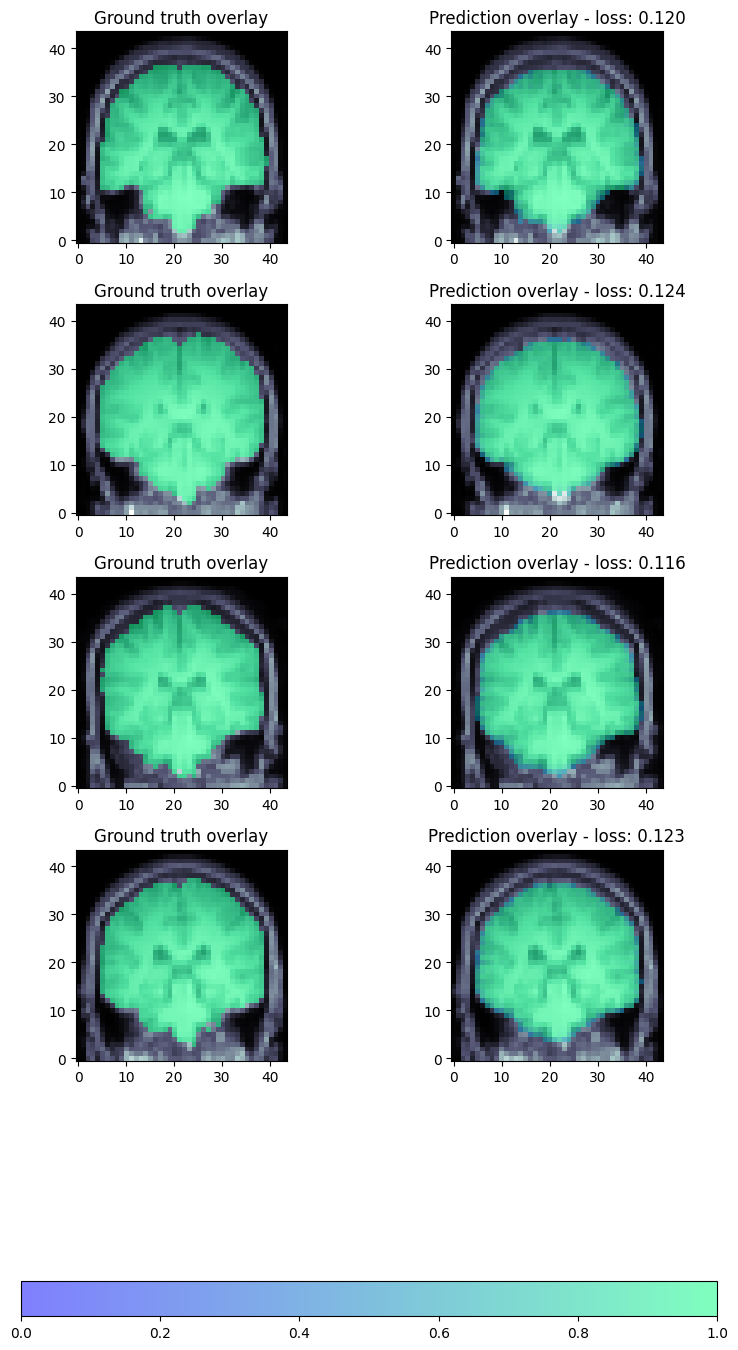

In [42]:
fig, ax = plt.subplots(4,2, figsize=(8,16))
slice_to_plot = 24
for i in range(4):
    (image_modalities, demographics), target = next(val_data_loader_iter)
    img = image_modalities['T1'][0, 0, ..., slice_to_plot]
    ax[i][0].imshow(img, cmap='bone', interpolation='none')
    label = target['label'][0, 1, ..., slice_to_plot]
    plot = ax[i][0].imshow(np.ma.masked_where(
                            label < 0.5, 
                            label), cmap='winter', alpha=0.5, interpolation='none', vmin=0., vmax=1.)
    ax[i][0].invert_yaxis()
    ax[i][0].set_title('Ground truth overlay')
    
    ax[i][1].imshow(img, cmap='bone', interpolation='none')
    prediction_3d = F.softmax(valid_model.forward(image_modalities['T1']), dim=1)
    prediction = prediction_3d[0, 1, ..., slice_to_plot].detach().numpy()
    plot = ax[i][1].imshow(np.ma.masked_where(
        prediction < 0.5,
        prediction), cmap='winter', alpha=0.5, interpolation='none', vmin=0., vmax=1.)
    ax[i][1].invert_yaxis()
    ax[i][1].set_title(f'Prediction overlay - loss: {losses[i]:0.3f}')
    
fig.tight_layout(pad=3.0)
fig.colorbar(plot, ax=ax, location='bottom')